In [1]:
import numpy as np
import os
import sys
import pandas as pd


import seaborn as sns

import pylab as pl
import h5py

import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
os.environ['CUDA_VISIBLE_DEVICES']="0" 

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

base_dir = '/media/tord/T7/Thesis_ssd/MasterThesis3/'
os.chdir(base_dir)

from GlobalUtils import GlobalUtils
utils = GlobalUtils()
os.chdir(utils.base_dir)
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.RamLoader import RamLoader
gen_dir = '/media/tord/T7/Thesis_ssd/MasterThesis3/Classes/DataProcessing'
os.chdir(gen_dir)
import ts_RamGenerator
os.chdir(base_dir)


helper = HelperFunctions()

import sys
ISCOLAB = 'google.colab' in sys.modules

import random
import pprint


1 Physical GPUs, 1 Logical GPUs


In [2]:
load_args = {
    'earth_explo_only' : True,
    'noise_earth_only' : False,
    'noise_not_noise' : False,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 1,
    'seed' : 1,
    'subsample_size' : 0.05,
    'balance_non_train_set' : False,
    'use_true_test_set' : False,
    'even_balance' : False
}
loadData = LoadData(**load_args)
full_ds, train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)

Mapping redundancy: [--------------------------------------->] 100 %



In [3]:
#gens = RamGenerator(loadData, handler)

In [4]:
use_time_augmentor = False
use_noise_augmentor = False
scaler_name = None
filter_name = None
band_min = 2.0
band_max = 4.0
highpass_freq = 0.1

load_test_set = False


ramLoader = RamLoader(loadData, 
                      handler, 
                      use_time_augmentor = use_time_augmentor, 
                      use_noise_augmentor = use_noise_augmentor, 
                      scaler_name = scaler_name,
                      filter_name = filter_name, 
                      band_min = band_min,
                      band_max = band_max,
                      highpass_freq = highpass_freq, 
                      load_test_set = False)
train_trace, train_label, val_trace, val_label, timeAug, scaler, noiseAug = ramLoader.load_to_ram()

Stage one loading training set: [--------------------------------------->] 100 %

Stage one loading validation set: [--------------------------------------->] 100 %

Completed loading to RAM


In [5]:
is_lstm = True
num_channels = 3

batch_size = 10

train_gen = threadsafe_generator.data_generator(val_trace, train_label, batch_size, loadData, handler, noiseAug, is_lstm = is_lstm, num_channels = num_channels)
#train_gen = gens.data_generator(train_trace, train_label, batch_size, is_lstm = is_lstm, num_channels = num_channels)
#val_gen = gens.data_generator(val_trace, val_label, batch_size, is_lstm = is_lstm, num_channels = num_channels)

In [13]:
train_gen

In [14]:
loadData

/media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2010-06-04T15.34.25.504000Z.h5
Original


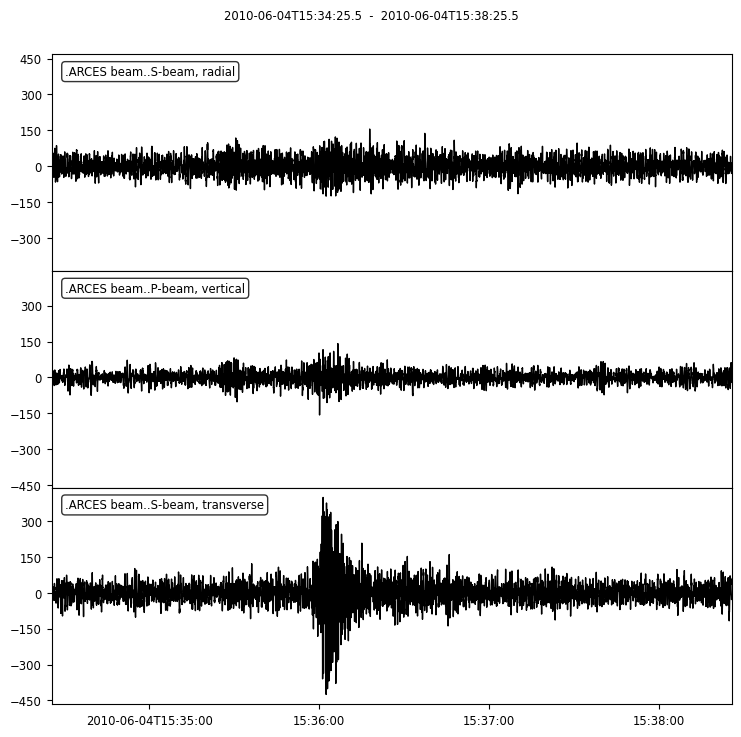

Modified


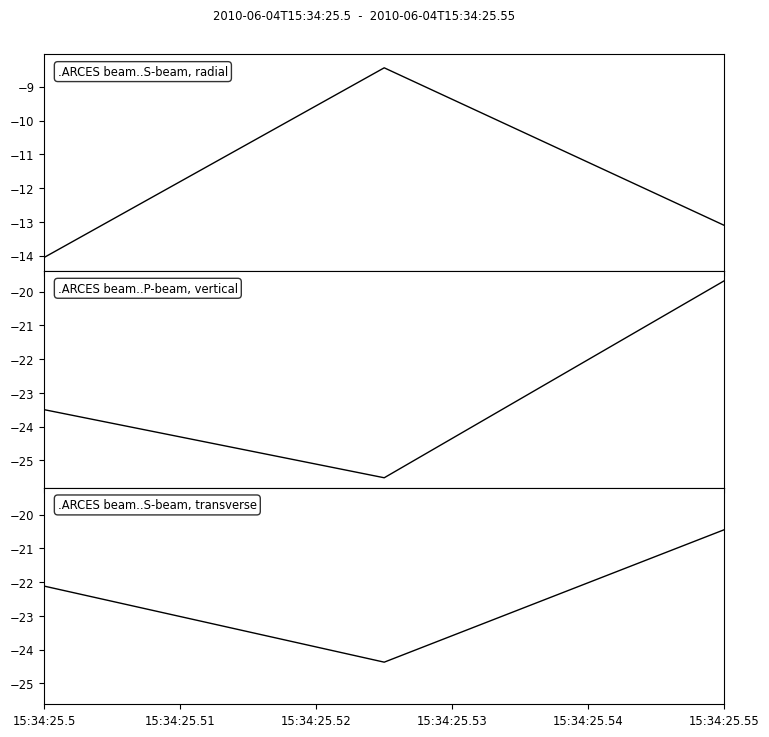

In [7]:
i = 0
sample_x = x[i]
trace, sample_info = handler.path_to_trace(train_ds[i][0])
print(train_ds[i][0])
if num_channels != 3:
    exp_trace = np.zeros((3, sample_x.shape[1]))
    for i in range(num_channels):
        exp_trace[i] = sample_x[i]
else:
    exp_trace = sample_x
        
print("Original")
helper.plot_event(trace, sample_info)
print("Modified")
helper.plot_event(exp_trace, sample_info)

In [8]:
import threadsafe_generator

In [9]:
ts_gen = threadsafe_generator.data_generator(val_trace, train_label, batch_size, loadData, handler, noiseAug, is_lstm = is_lstm, num_channels = num_channels)

In [10]:
next(ts_gen)

(array([[[ -2.34973373e+01,  -2.55139694e+01,  -1.96799374e+01],
         [ -2.21183338e+01,  -2.43708954e+01,  -2.04480991e+01],
         [ -1.40545330e+01,  -8.43911743e+00,  -1.31051550e+01],
         ..., 
         [ -8.82742691e+01,  -7.12797852e+01,  -4.97844658e+01],
         [ -2.62626801e+01,  -1.45627098e+01,  -1.01084528e+01],
         [ -2.30423093e+00,   7.09098387e+00,   1.65455055e+01]],
 
        [[ -9.53161621e+00,  -1.10558252e+01,  -1.00231142e+01],
         [ -4.38106680e+00,   1.89641917e+00,   8.45412159e+00],
         [  1.57068586e+01,   1.78053093e+01,   1.51872911e+01],
         ..., 
         [ -8.72442245e+01,  -8.57793350e+01,  -7.67336655e+01],
         [ -4.81377220e+01,  -1.62343311e+01,  -2.12860870e+00],
         [  5.11636829e+00,   2.35679588e+01,   4.24845695e+01]],
 
        [[  6.79150848e+01,   7.10418015e+01,   5.94588547e+01],
         [  5.07125969e+01,   4.63344688e+01,   3.24661980e+01],
         [  9.40323353e+00,  -2.33179607e+01,  -5.6635

In [11]:

import numpy as np
import random

import os
import sys
import threading

#from .DataHandler import DataHandler

class threadsafe_iter:

    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def next(self):
        with self.lock:
            return self.it.next()


        
def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

@threadsafe_generator
class RamGenerator(DataHandler):
    
    """
    After further inspection in RamGeneratorDevelop.ipynb, this class behaves as expected.
    """
    
    def __init__(self, loadData, handler, noiseAug = None):
        super().__init__(loadData)
        self.handler = handler
        self.num_classes = len(set(loadData.label_dict.values()))
        self.noiseAug = noiseAug

    
        
    
    def data_generator(self, traces, labels, batch_size, num_channels = 3, is_lstm = False):
        """
        Creates a generator object which yields two arrays. One array for waveforms, and one array for labels
        """
        # Number of samples 
        num_samples = len(labels)
        while True:
            # Loop which goes from 0 to num_samples, jumping n number for each loop, where n is equal to batch_size
            for offset in range(0, num_samples, batch_size):
                # Initiates the arrays.
                batch_traces = np.empty((batch_size, traces.shape[1], traces.shape[2]))
                batch_labels = np.empty((batch_size, 1))
                # If condition that handles what happens when the funcion has been called k times, and k*batch_size > num_samples.
                # This makes sure that the shape of the arrays remain the same, even though there arent enough events to fill an entire batch.
                # when this condition is true, it will be the last iteration of the loop, so at next call the iterator will start at 0 again.
                if offset + batch_size > num_samples:
                    overflow = offset + batch_size - num_samples

                    batch_traces[0:batch_size - overflow] = traces[offset:(offset+batch_size) - overflow]
                    batch_labels[0:batch_size - overflow] = labels[offset:(offset+batch_size) - overflow]

                    i_start = random.randint(0, num_samples-overflow)
                    batch_traces[batch_size - overflow:batch_size] = traces[i_start:i_start + overflow]
                    batch_labels[batch_size - overflow:batch_size] = labels[i_start:i_start + overflow]
                # Regular trucking along here
                else:
                    batch_traces = traces[offset:offset + batch_size]
                    batch_labels = labels[offset:offset + batch_size]

                # Adds a little noise to each event, as a regulatory measure
                if self.noiseAug != None:
                    batch_traces = self.preprocess_data(batch_traces)

                batch_traces = batch_traces[:][:,0:num_channels]
                if is_lstm:
                    batch_traces = np.reshape(batch_traces, (batch_traces.shape[0], batch_traces.shape[2], batch_traces.shape[1]))

                yield batch_traces, batch_labels
                
    def preprocess_data(self, traces):
        return self.noiseAug.batch_augment_noise(traces, 0, self.noiseAug.noise_std/10)